<a href="https://colab.research.google.com/github/roshmita/amazon-stock-lstm/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import yfinance as yf
from datetime import timedelta

### Fetching Data from Yahoo Finance

In [2]:
def fetch_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="10y")
    return hist

ticker = "AMZN"  # Example ticker
data = fetch_data(ticker)

# Convert the index to just date (remove time part)
data.index = data.index.date

### Exploratory Data Analysis

In [3]:
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2025-03-17,198.770004,199.000000,194.320007,195.740005,47341800,0.0,0.0
2025-03-18,192.520004,194.000000,189.380005,192.820007,40414900,0.0,0.0
2025-03-19,193.380005,195.970001,191.960007,195.539993,39442900,0.0,0.0
2025-03-20,193.070007,199.320007,192.300003,194.949997,38921100,0.0,0.0
2025-03-21,192.899994,196.990005,192.520004,196.210007,60005300,0.0,0.0


In [4]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2015-03-23,18.903500,19.088499,18.747000,18.755501,44786000,0.0,0.0
2015-03-24,18.699499,18.761999,18.613501,18.704500,44564000,0.0,0.0
2015-03-25,18.758499,19.025000,18.514500,18.548000,68590000,0.0,0.0
2015-03-26,18.479500,18.570000,18.282499,18.367500,58600000,0.0,0.0
2015-03-27,18.355499,18.658501,18.328501,18.528000,52196000,0.0,0.0


In [5]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.0,2516.000000
mean,105.590351,106.782757,104.272528,105.558756,7.531889e+07,0.0,0.007949
std,55.422315,56.044176,54.718536,55.388493,3.984568e+07,0.0,0.398726
min,18.355499,18.570000,18.282499,18.367500,1.500750e+07,0.0,0.000000
25%,50.024376,50.301000,49.600751,49.832125,4.986165e+07,0.0,0.000000
50%,96.421749,97.322498,95.051502,96.194248,6.491330e+07,0.0,0.000000
75%,156.904999,158.850498,154.768875,156.807251,8.933000e+07,0.0,0.000000
max,239.020004,242.520004,238.029999,242.059998,4.381880e+08,0.0,20.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 2015-03-23 to 2025-03-21
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float64
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null   float64
 4   Volume        2516 non-null   int64  
 5   Dividends     2516 non-null   float64
 6   Stock Splits  2516 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 221.8+ KB


<Axes: >

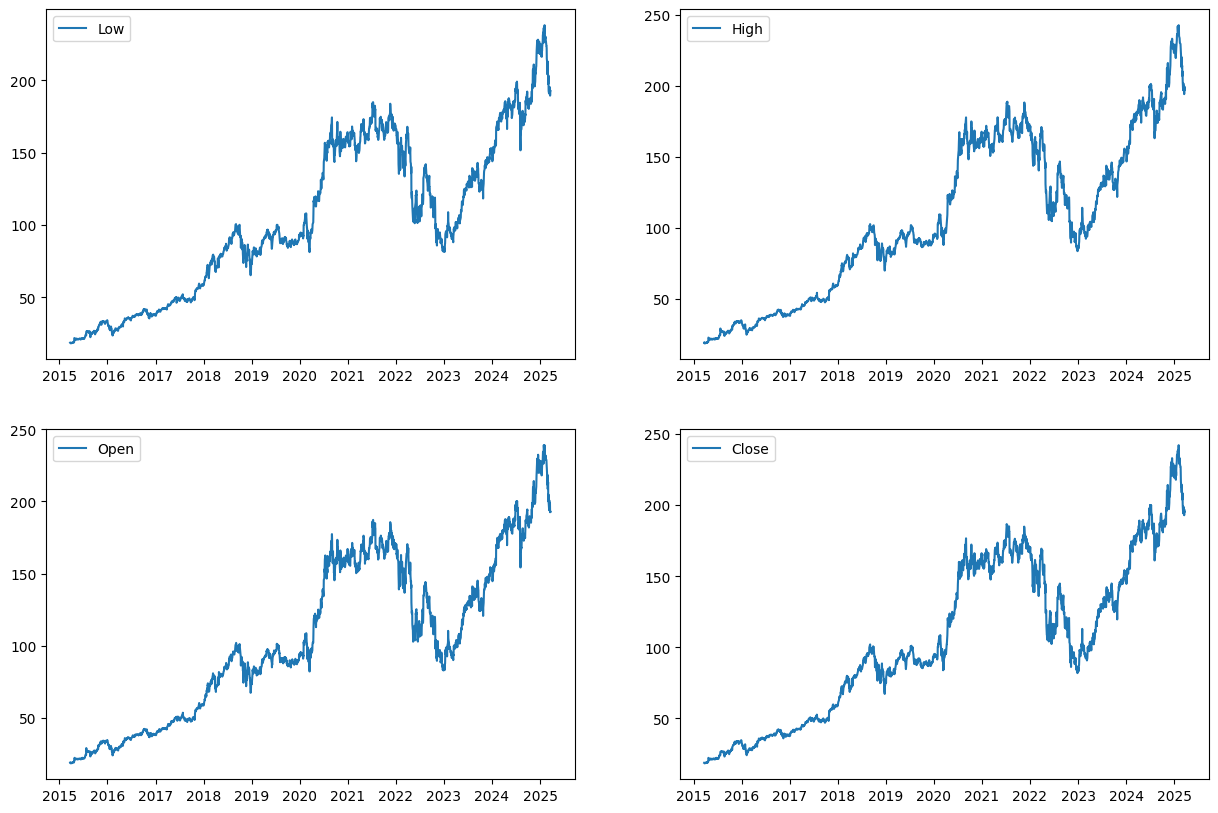

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
data[['Low']].plot(ax = axes[0,0])
data[['High']].plot(ax = axes[0,1])
data[['Open']].plot(ax = axes[1,0])
data[['Close']].plot(ax = axes[1,1])

In [8]:
data['Daily Return'] = data['Close'].pct_change()
data['Spread'] = data['High'] - data['Low']

In [9]:
ma_day = [10, 15, 30, 60]
for ma in ma_day:
    column_name = f"MA_{ma}days"
    data[column_name] = data['Close'].rolling(ma).mean()

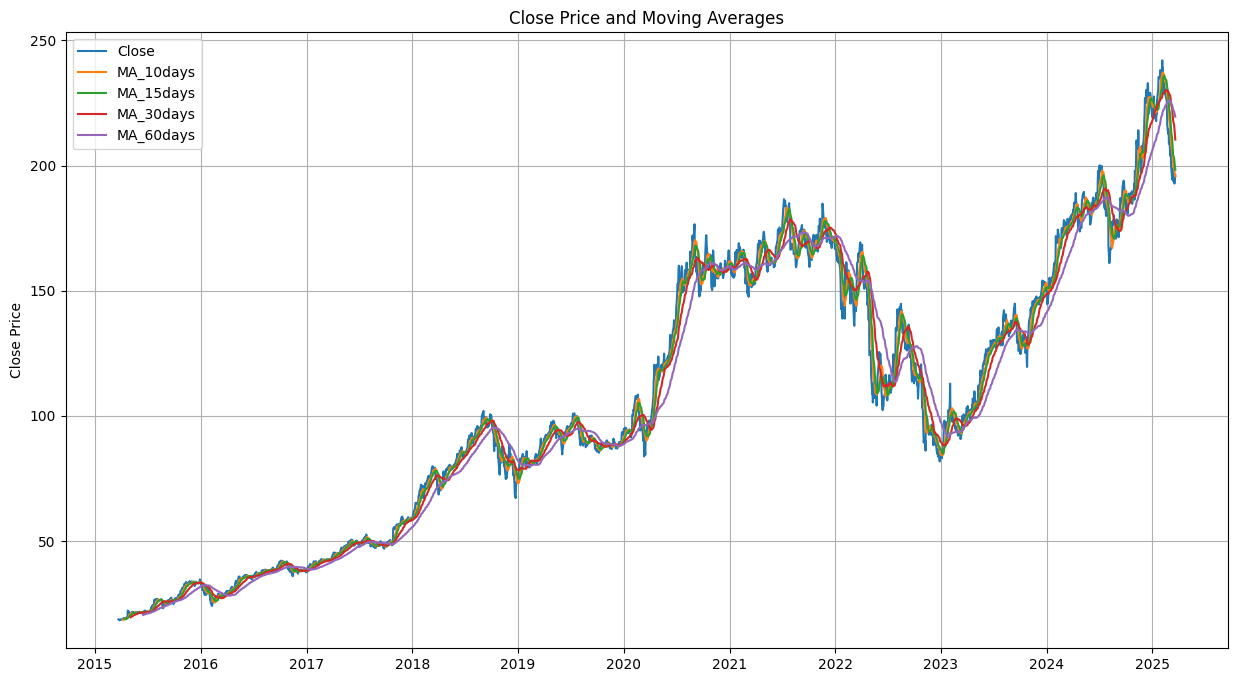

In [10]:
data[['Close', 'MA_10days', 'MA_15days', 'MA_30days', 'MA_60days']].plot(figsize=(15, 8))
plt.title('Close Price and Moving Averages')
plt.ylabel('Close Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [11]:
cols = ['Open', 'Close', 'Volume', 'High', 'Low', 'Daily Return', 'Spread']
correlation_matrix = data[cols].corr()
correlation_matrix['Close']

,Close
Open,0.999413
Close,1.000000
Volume,-0.245314
High,0.999728
Low,0.999744
Daily Return,-0.004826
Spread,0.677190


In [12]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Spread,MA_10days,MA_15days,MA_30days,MA_60days
2015-03-23,18.903500,19.088499,18.747000,18.755501,44786000,0.0,0.0,NaN,0.341499,NaN,NaN,NaN,NaN
2015-03-24,18.699499,18.761999,18.613501,18.704500,44564000,0.0,0.0,-0.002719,0.148499,NaN,NaN,NaN,NaN
2015-03-25,18.758499,19.025000,18.514500,18.548000,68590000,0.0,0.0,-0.008367,0.510500,NaN,NaN,NaN,NaN
2015-03-26,18.479500,18.570000,18.282499,18.367500,58600000,0.0,0.0,-0.009732,0.287500,NaN,NaN,NaN,NaN
2015-03-27,18.355499,18.658501,18.328501,18.528000,52196000,0.0,0.0,0.008738,0.330000,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Amazon Daily Returns')

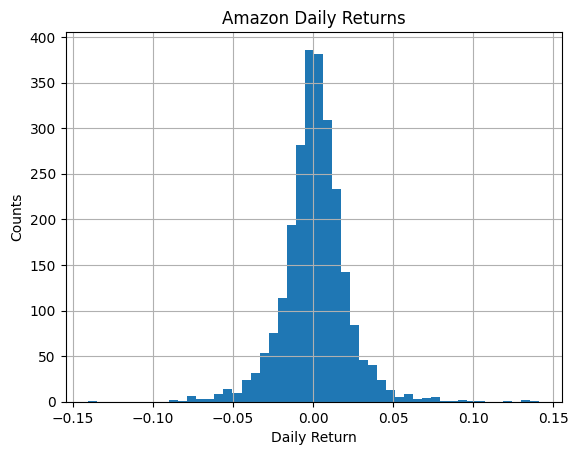

In [13]:
data['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Amazon Daily Returns')

In [14]:
# Normalize and create sequences
def create_sequences(data, seq_length):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    sequences, labels = [], []
    for i in range(len(data_scaled) - seq_length):
        sequences.append(data_scaled[i:i+seq_length])
        labels.append(data_scaled[i+seq_length, 0])
    return np.array(sequences), np.array(labels), scaler

In [15]:
df = data[['Close', 'Open', 'High', 'Low']]

In [16]:
# Load & preprocess data
seq_length = 60  # Use past 60 days to predict next day
X, y, scaler = create_sequences(df.values, seq_length)

In [17]:
X.shape

(2456, 60, 4)

In [18]:
# Train-val-test split
train_split = int(0.8 * len(X))
val_split = int(0.9 * len(X))
X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

In [19]:
print(X_train.shape, X_val.shape, X_test.shape)

(1964, 60, 4) (246, 60, 4) (246, 60, 4)


In [20]:
print(y_train.shape, y_val.shape, y_test.shape)

(1964,) (246,) (246,)


In [21]:
# Build LSTM Model
model = Sequential([
    LSTM(units = 128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # Adjust input_shape
    Dropout(0.2),
    LSTM(units = 128, return_sequences=True),
    Dropout(0.2),
    LSTM(units = 64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(1)  # Output layer - Adjust to match y_train shape
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,201 (981.25 KB)

 Trainable params: 251,201 (981.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,201 (981.25 KB)

 Trainable params: 251,201 (981.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)

In [24]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stop, lr_scheduler])

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 0.0213 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0011 - val_loss: 5.6728e-04 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - loss: 9.8199e-04 - val_loss: 5.3953e-04 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - loss: 8.3889e-04 - val_loss: 7.6597e-04 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - loss: 7.7782e-04 - val_loss: 4.7064e-04 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0010 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - loss: 7.5528e-04 - val_loss: 4.5508e-04 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - loss: 6.8473e-04 - val_loss: 4.4715e-04 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss

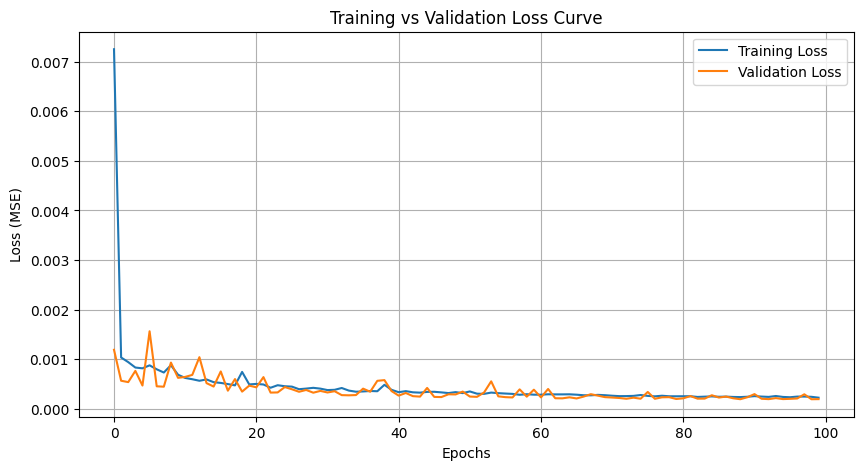

In [25]:
def plot_loss(history):
    """
    Plots the training and validation loss curves.

    Parameters:
    history : Keras History object from model.fit()
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training your model
plot_loss(history)

In [26]:
# Evaluate model on test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = model.predict(X_test)

# Create an empty array matching the original feature count (5 columns)
y_pred_full = np.zeros((y_pred.shape[0], scaler.data_min_.shape[0]))  # Ensure correct column count

# Assign Close price predictions to the correct column (last one)
y_pred_full[:, -1] = y_pred[:, 0]

# Apply inverse transform
y_pred_actual = scaler.inverse_transform(y_pred_full)[:, -1]  # Extract Close price

# Do the same for y_test (actual values)
y_test_full = np.zeros((y_test.shape[0], scaler.data_min_.shape[0]))
y_test_full[:, -1] = y_test.reshape(-1)  # Assign actual Close prices

# Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test_full)[:, -1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.0178e-04
Test Loss: 0.0005459260428324342
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


In [27]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  0.017991242569852243


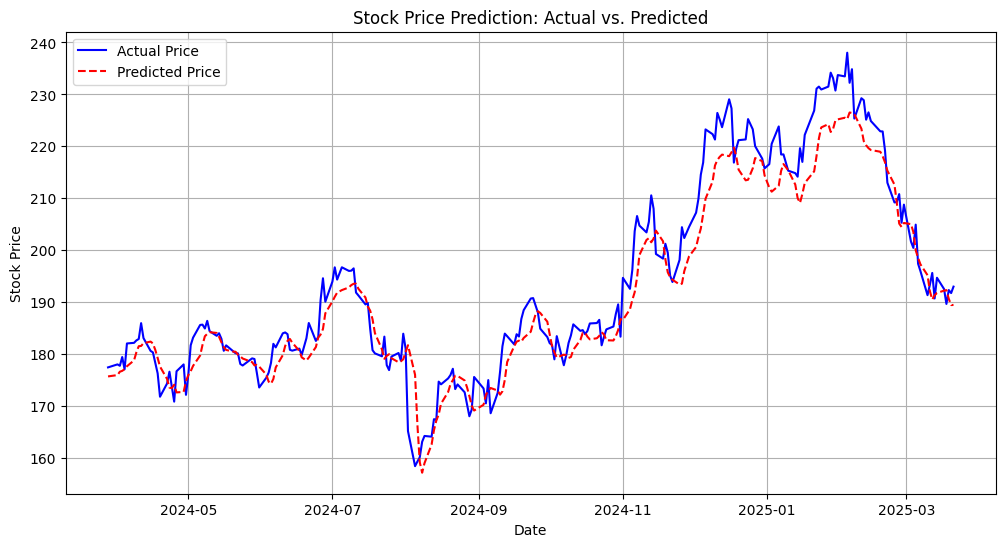

In [28]:
# Ensure y_pred and y_test are numpy arrays
y_pred = np.array(y_pred).reshape(-1, 1)  # Reshape to (n_samples, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Create placeholder arrays with the same feature shape as during training
y_pred_full = np.zeros((len(y_pred), scaler.n_features_in_))  # (n_samples, num_features)
y_test_full = np.zeros((len(y_test), scaler.n_features_in_))

# Fill only the last column (Close price) with the predictions
y_pred_full[:, -1] = y_pred.flatten()
y_test_full[:, -1] = y_test.flatten()

# Apply inverse transformation
y_pred_actual = scaler.inverse_transform(y_pred_full)[:, -1]  # Extract only Close price
y_test_actual = scaler.inverse_transform(y_test_full)[:, -1]

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color="blue")
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Price", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs. Predicted")
plt.legend()
plt.grid(True)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


<ipython-input-29-b811f801e229>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1, 0] = pred  # Only update Close price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


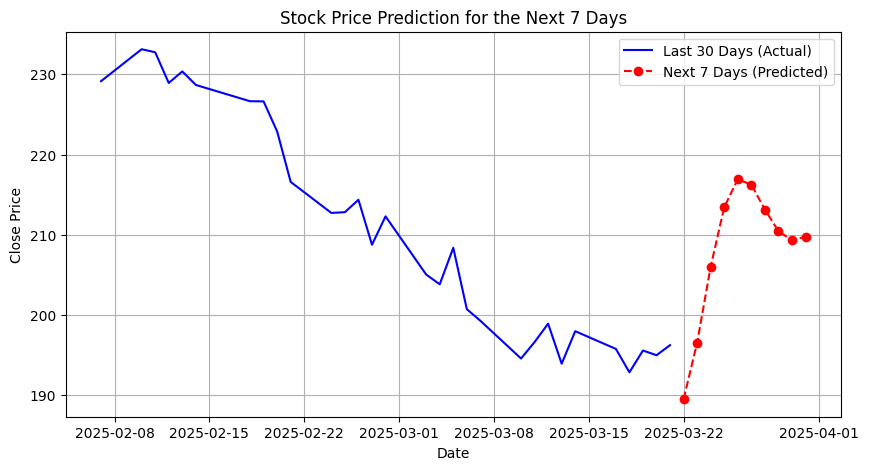

,Date,Predicted Close Price
0,2025-03-22,189.46
1,2025-03-23,196.52
2,2025-03-24,206.02
3,2025-03-25,213.44
4,2025-03-26,216.92
5,2025-03-27,216.23
6,2025-03-28,213.13


In [29]:
def predict_future(n_days, last_sequence, model, scaler):
    """
    Predicts future stock prices for the next n_days.

    Parameters:
    - n_days : int, number of days to predict
    - last_sequence : numpy array, last available sequence for prediction
    - model : trained LSTM model
    - scaler : fitted MinMaxScaler for inverse transformation

    Returns:
    - future_dates : list, generated future dates
    - future_prices : numpy array, predicted prices (in original scale)
    """
    future_preds = []
    current_seq = last_sequence.copy()

    for _ in range(n_days):
        pred = model.predict(current_seq.reshape(1, seq_length, current_seq.shape[1]))  # Dynamic shape handling
        future_preds.append(pred[0, 0])

        # Shift and update only the Close price (last column)
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred  # Only update Close price

    # Convert predictions back to original scale
    future_preds_full = np.zeros((n_days, current_seq.shape[1]))  # Empty array with same feature count
    future_preds_full[:, -1] = future_preds  # Assign predicted Close prices
    future_prices = scaler.inverse_transform(future_preds_full)[:, -1]  # Extract Close price

    # Generate future dates
    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i) for i in range(1, n_days + 1)]

    return future_dates, future_prices

# Predict next 7 days
future_dates, future_prices = predict_future(10, X_test[-1], model, scaler)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df.index[-30:], df["Close"].values[-30:], label="Last 30 Days (Actual)", color="blue")
plt.plot(future_dates, future_prices, label="Next 7 Days (Predicted)", color="red", linestyle="dashed", marker="o")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Prediction for the Next 7 Days")
plt.legend()
plt.grid(True)
plt.show()

# Print predicted future prices with dates
future_predictions_df = pd.DataFrame({"Date": future_dates, "Predicted Close Price": future_prices.flatten()})
future_predictions_df['Predicted Close Price'] = future_predictions_df['Predicted Close Price'].round(2)
future_predictions_df.head(7)